In [1]:
import sys
sys.path.append("../")
sys.path.append("../../")

import os
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from predict import predict
from open_data import open_data, create_global_batch,get_df_stats,apply_norm
from dataset import RadarDataset,RadarCollate
from encoder_decoder_clean import lstm_seq2seq
from simple_model import LSTM
from train import train
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from torch.utils.data import DataLoader

In [29]:
PATH_CSV="/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv" #"/Users/clemencevast/Documents/Courses/MachineLearning/RadarTrafficData_files/Radar_Traffic_Counts.csv" #"/Users/iris/Documents/radar_deep/Radar_Traffic_Counts.csv"
radar_name=' CAPITAL OF TEXAS HWY / LAKEWOOD DR'
DAYS_INPUT=7
WINDOW_LABEL=1
INPUT_SIZE=(DAYS_INPUT)*24*4
OUTPUT_SIZE=(WINDOW_LABEL)*24*4
TOTAL_DAYS=100
batch_size = 1

In [30]:
df1=open_data(PATH_CSV, direction="NB", radar=radar_name, year=2018)

In [31]:
batch_df=create_global_batch(df1, window_x_day=DAYS_INPUT, window_label_day=WINDOW_LABEL, gap_acquisition=1, tot_len_day=TOTAL_DAYS)
df_mean,df_std=get_df_stats(batch_df)
new_data=apply_norm(batch_df,df_mean,df_std)


Building batch 0 
 x begin 2018-01-02 label begin 2018-01-09 end period 2018-04-04 
Building batch 1 
 x begin 2018-01-03 label begin 2018-01-10 end period 2018-04-04 
Building batch 2 
 x begin 2018-01-04 label begin 2018-01-11 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-05 label begin 2018-01-12 end period 2018-04-04 
We do not have all the dates for the time period in label , 96 42
Building batch 3 
 x begin 2018-01-06 label begin 2018-01-13 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-07 label begin 2018-01-14 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-08 label begin 2018-01-15 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-09 label begin 2018-01-16 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-10 label begin 2018-01-17 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-11 label begin 2018-01-18 end period 2018-04-04 
Building batch 3 
 x begin 2018-01-12 label begin 2018-01-19 end period 2018-04-04 
Building b

Building batch 38 
 x begin 2018-03-19 label begin 2018-03-26 end period 2018-04-04 
Building batch 39 
 x begin 2018-03-20 label begin 2018-03-27 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-21 label begin 2018-03-28 end period 2018-04-04 
We do not have all the dates for the time period in label , 96 54
Building batch 40 
 x begin 2018-03-22 label begin 2018-03-29 end period 2018-04-04 
We do not have all the dates for the time period in x , 672 630
Building batch 40 
 x begin 2018-03-23 label begin 2018-03-30 end period 2018-04-04 
We do not have all the dates for the time period in x , 672 630
Building batch 40 
 x begin 2018-03-24 label begin 2018-03-31 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-25 label begin 2018-04-01 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-26 label begin 2018-04-02 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-27 label begin 2018-04-03 end period 2018-04-04 
Building batch 40 
 x begin 2018-03-28 la

In [32]:
def plot_predict(dic_model,valloader,lcolor=None):
    if lcolor is None:
        lcolor=["blue","red","green","orange","purple"]
    for seq,label in valloader:
        for i,name_model in enumerate(dic_model): #dic torch_name, torchmodel
            model=dic_model[name_model]
            fig,ax=plt.subplots()
            seq_len=label.shape[1]
            pred=model.predict(seq,seq_len)
            print(pred.shape)
            print(label.shape)
            xpred=pred.reshape(seq_len)
            xlab=label.squeeze(0).detach().numpy()
            ax.plot([i for i in range(seq_len)],xpred,locor[i], label="pred_{}".format(name_model))
        ax.plot([i for i in range(seq_len)],xlab,label="label")
    ax.legend()
    plt.show()

In [33]:
fullset = RadarDataset(dataframe=batch_df,transform=None)
ptrain,pval,ptest=0.7,0.15,0.15
trainglobdataset, testdataset = train_test_split(fullset, test_size=ptest,shuffle=False)
traindataset, valdataset = train_test_split(trainglobdataset, test_size=pval/(1-ptest),shuffle=False)
collate_fn = RadarCollate()
trainloader = DataLoader(traindataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
valloader = DataLoader(valdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
testloader = DataLoader(testdataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)
(96,)


# Training LSTM encoder decoder

In [34]:
input_dim = 1   
hidden_dim = 1
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1
epochs=100
batch_size=1

In [35]:
model_seq2seq=lstm_seq2seq(1, hidden_dim)

In [ ]:
iteration2,losses2,loss_val_list2=model_seq2seq.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='teacher_forcing', teacher_forcing_ratio=0.5, learning_rate=0.005, dynamic_tf=False,name_model="new_encode_decod_lre-3",save=True,ite_print=2)

  2%|▏         | 2/100 [00:13<10:30,  6.43s/it, loss=0.137]

epoch 1 loss train 0.13684473439518893 loss val 0.3971903622150421


  4%|▍         | 4/100 [00:26<10:31,  6.57s/it, loss=0.037]

epoch 3 loss train 0.037041300641638894 loss val 0.20207804441452026


  6%|▌         | 6/100 [00:39<10:15,  6.55s/it, loss=0.032]

epoch 5 loss train 0.0316832893128906 loss val 0.19982005655765533


  8%|▊         | 8/100 [00:52<10:01,  6.54s/it, loss=0.029]

epoch 7 loss train 0.029441877933485166 loss val 0.19820697605609894


 10%|█         | 10/100 [01:06<10:11,  6.80s/it, loss=0.028]

epoch 9 loss train 0.02783185157126614 loss val 0.19736014306545258


 12%|█▏        | 12/100 [01:19<10:02,  6.85s/it, loss=0.028]

epoch 11 loss train 0.028134011863065616 loss val 0.19677506387233734


 14%|█▍        | 14/100 [01:33<09:43,  6.78s/it, loss=0.026]

epoch 13 loss train 0.02560591567972941 loss val 0.1963592767715454


 16%|█▌        | 16/100 [01:47<09:52,  7.06s/it, loss=0.025]

epoch 15 loss train 0.025408141215198805 loss val 0.19442398846149445


 18%|█▊        | 18/100 [02:01<09:25,  6.90s/it, loss=0.024]

epoch 17 loss train 0.024268023137535368 loss val 0.19241701066493988


 20%|██        | 20/100 [02:14<09:13,  6.92s/it, loss=0.023]

epoch 19 loss train 0.022525046885545765 loss val 0.19229963421821594


 22%|██▏       | 22/100 [02:28<09:07,  7.02s/it, loss=0.020]

epoch 21 loss train 0.020028013819163398 loss val 0.18523970246315002


 24%|██▍       | 24/100 [02:41<08:33,  6.76s/it, loss=0.019]

epoch 23 loss train 0.01866810502750533 loss val 0.16864891350269318


 26%|██▌       | 26/100 [02:55<08:19,  6.75s/it, loss=0.017]

epoch 25 loss train 0.016929470751035427 loss val 0.14104868471622467


 28%|██▊       | 28/100 [03:08<08:05,  6.74s/it, loss=0.017]

epoch 27 loss train 0.0173957193037495 loss val 0.14292481541633606


 30%|███       | 30/100 [03:22<08:00,  6.87s/it, loss=0.013]

epoch 29 loss train 0.012899367221897202 loss val 0.12155527621507645


 32%|███▏      | 32/100 [03:35<07:46,  6.86s/it, loss=0.016]

epoch 31 loss train 0.015918549042128558 loss val 0.13898251950740814


 34%|███▍      | 34/100 [03:48<07:22,  6.70s/it, loss=0.014]

epoch 33 loss train 0.013515758461185865 loss val 0.1171753853559494


 36%|███▌      | 36/100 [04:01<06:57,  6.52s/it, loss=0.014]

epoch 35 loss train 0.013757027560911541 loss val 0.1114688441157341


 38%|███▊      | 38/100 [04:14<06:43,  6.51s/it, loss=0.017]

epoch 37 loss train 0.017344544616727426 loss val 0.1352139562368393


 40%|████      | 40/100 [04:27<06:36,  6.61s/it, loss=0.017]

epoch 39 loss train 0.017079404023076807 loss val 0.14366398751735687


 42%|████▏     | 42/100 [04:41<06:27,  6.68s/it, loss=0.013]

epoch 41 loss train 0.013310364871618472 loss val 0.1393316686153412


 44%|████▍     | 44/100 [04:54<06:15,  6.71s/it, loss=0.012]

epoch 43 loss train 0.012222694540728949 loss val 0.10488756000995636


 46%|████▌     | 46/100 [05:07<06:02,  6.72s/it, loss=0.016]

epoch 45 loss train 0.016145419046681906 loss val 0.1256028115749359


 48%|████▊     | 48/100 [05:20<05:38,  6.50s/it, loss=0.014]

epoch 47 loss train 0.013915725809056312 loss val 0.10775760561227798


 50%|█████     | 50/100 [05:32<05:20,  6.42s/it, loss=0.013]

epoch 49 loss train 0.012918560973568154 loss val 0.11087076365947723


 52%|█████▏    | 52/100 [05:45<05:12,  6.52s/it, loss=0.017]

epoch 51 loss train 0.016621827422308603 loss val 0.10663431137800217


 54%|█████▍    | 54/100 [05:58<04:57,  6.48s/it, loss=0.013]

epoch 53 loss train 0.013165171391197614 loss val 0.10232234746217728


 56%|█████▌    | 56/100 [06:11<04:43,  6.44s/it, loss=0.017]

epoch 55 loss train 0.017252261434415623 loss val 0.16437597572803497


 58%|█████▊    | 58/100 [06:23<04:28,  6.38s/it, loss=0.015]

epoch 57 loss train 0.015329455033809478 loss val 0.10615125298500061


 60%|██████    | 60/100 [06:36<04:13,  6.34s/it, loss=0.016]

epoch 59 loss train 0.015863424657644436 loss val 0.12259683012962341


 62%|██████▏   | 62/100 [06:49<04:06,  6.48s/it, loss=0.018]

epoch 61 loss train 0.01797656827173861 loss val 0.13586072623729706


 64%|██████▍   | 64/100 [07:02<03:54,  6.51s/it, loss=0.014]

epoch 63 loss train 0.01367357186973095 loss val 0.10994583368301392


 66%|██████▌   | 66/100 [07:15<03:42,  6.53s/it, loss=0.014]

epoch 65 loss train 0.013624567979214979 loss val 0.10932262241840363


 68%|██████▊   | 68/100 [07:28<03:26,  6.47s/it, loss=0.015]

epoch 67 loss train 0.015132020676641591 loss val 0.1500995010137558


 70%|███████   | 70/100 [07:40<03:13,  6.43s/it, loss=0.016]

epoch 69 loss train 0.01563823625578412 loss val 0.10750876367092133


 72%|███████▏  | 72/100 [07:53<02:58,  6.39s/it, loss=0.013]

epoch 71 loss train 0.01256701597178887 loss val 0.10300618410110474


 74%|███████▍  | 74/100 [08:06<02:46,  6.39s/it, loss=0.014]

epoch 73 loss train 0.013932803363007094 loss val 0.11403319239616394


 76%|███████▌  | 76/100 [08:19<02:34,  6.44s/it, loss=0.013]

epoch 75 loss train 0.013186338507304234 loss val 0.10954885929822922


 78%|███████▊  | 78/100 [08:31<02:21,  6.44s/it, loss=0.016]

epoch 77 loss train 0.015866624008465027 loss val 0.11415090411901474


 80%|████████  | 80/100 [08:44<02:10,  6.50s/it, loss=0.015]

epoch 79 loss train 0.015314460166596941 loss val 0.12378289550542831


 82%|████████▏ | 82/100 [08:57<01:55,  6.43s/it, loss=0.015]

epoch 81 loss train 0.014666242982327406 loss val 0.14422154426574707


 84%|████████▍ | 84/100 [09:10<01:42,  6.42s/it, loss=0.014]

epoch 83 loss train 0.0140755440391201 loss val 0.11803105473518372


 86%|████████▌ | 86/100 [09:23<01:30,  6.48s/it, loss=0.015]

epoch 85 loss train 0.014865965915045567 loss val 0.2217477560043335


 88%|████████▊ | 88/100 [09:36<01:18,  6.53s/it, loss=0.014]

epoch 87 loss train 0.014185982872731984 loss val 0.10807746648788452


 90%|█████████ | 90/100 [09:48<01:04,  6.48s/it, loss=0.014]

epoch 89 loss train 0.013924381945149176 loss val 0.22447049617767334


 92%|█████████▏| 92/100 [10:01<00:51,  6.43s/it, loss=0.014]

epoch 91 loss train 0.014496044097800873 loss val 0.10599225759506226


 94%|█████████▍| 94/100 [10:14<00:38,  6.48s/it, loss=0.014]

epoch 93 loss train 0.013926553465093352 loss val 0.11520400643348694


 96%|█████████▌| 96/100 [10:27<00:25,  6.47s/it, loss=0.014]

epoch 95 loss train 0.014404196441838784 loss val 0.10914821922779083


 98%|█████████▊| 98/100 [10:39<00:12,  6.42s/it, loss=0.019]

epoch 97 loss train 0.01863449260625722 loss val 0.14652800559997559


In [ ]:
fig,ax=plt.subplots()
ax.plot([i for i in range(len(loss_val_list2))],loss_val_list2)

Change in the learning rate

In [8]:
model_seq2seq_lr2=lstm_seq2seq(1, hidden_dim)

In [9]:
iteration,losses,loss_val_list=model_seq2seq_lr2.train_model(trainloader,valloader,100, output_dim, batch_size=batch_size,
                    training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=0.001, dynamic_tf=False,ite_print=2)

  1%|          | 1/100 [00:04<07:37,  4.62s/it, loss=1.257]/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_seq2seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type lstm_encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve

epoch 1 loss train 0.03384886350896624 loss val 0.12227509915828705


  4%|▍         | 4/100 [00:18<07:27,  4.66s/it, loss=0.024]

epoch 3 loss train 0.02413330397879084 loss val 0.07415606081485748


  4%|▍         | 4/100 [00:19<07:54,  4.94s/it, loss=0.024]


KeyboardInterrupt: 

In [10]:
hidden_dim = 256

In [11]:
model_seq2seq_lr3=lstm_seq2seq(1, hidden_dim)

In [12]:
iteration3,losses3,loss_val_list3=model_seq2seq_lr3.train_model(trainloader,valloader,500, output_dim, batch_size=batch_size,
                    training_prediction='teacher_forcing', teacher_forcing_ratio=0.3, learning_rate=0.01, dynamic_tf=True,ite_print=2)

  0%|          | 2/500 [00:15<1:03:34,  7.66s/it, loss=0.028]

epoch 1 loss train 0.027960536018427875 loss val 0.08699557185173035


  1%|          | 4/500 [00:29<1:00:19,  7.30s/it, loss=0.019]

epoch 3 loss train 0.018791050960620243 loss val 0.0746573880314827


  1%|          | 6/500 [00:43<58:53,  7.15s/it, loss=0.019]  

epoch 5 loss train 0.018517837963170476 loss val 0.0722561925649643


  2%|▏         | 8/500 [00:57<58:34,  7.14s/it, loss=0.018]

epoch 7 loss train 0.018346770976980526 loss val 0.07273520529270172


  2%|▏         | 10/500 [01:11<57:48,  7.08s/it, loss=0.018]

epoch 9 loss train 0.017941217300378613 loss val 0.07257818430662155


  2%|▏         | 12/500 [01:25<56:53,  7.00s/it, loss=0.019]

epoch 11 loss train 0.018603216856718063 loss val 0.07812640070915222


  3%|▎         | 14/500 [01:38<56:03,  6.92s/it, loss=0.018]

epoch 13 loss train 0.01837108361845215 loss val 0.07562999427318573


  3%|▎         | 16/500 [01:52<55:32,  6.89s/it, loss=0.019]

epoch 15 loss train 0.01923552357281248 loss val 0.07437751442193985


  4%|▎         | 18/500 [02:06<55:24,  6.90s/it, loss=0.018]

epoch 17 loss train 0.018139162049111392 loss val 0.07149194926023483


  4%|▍         | 20/500 [02:20<55:56,  6.99s/it, loss=0.018]

epoch 19 loss train 0.018056495684302516 loss val 0.07602014392614365


  4%|▍         | 22/500 [02:34<55:34,  6.97s/it, loss=0.019]

epoch 21 loss train 0.018593077910029225 loss val 0.07496295124292374


  5%|▍         | 24/500 [02:47<55:01,  6.94s/it, loss=0.018]

epoch 23 loss train 0.01803361453736822 loss val 0.07341086864471436


  5%|▌         | 26/500 [03:01<54:56,  6.95s/it, loss=0.018]

epoch 25 loss train 0.018100748407757945 loss val 0.07220607995986938


  6%|▌         | 28/500 [03:15<54:45,  6.96s/it, loss=0.019]

epoch 27 loss train 0.018826558565100033 loss val 0.07390785217285156


  6%|▌         | 30/500 [03:29<54:11,  6.92s/it, loss=0.018]

epoch 29 loss train 0.018367363191727135 loss val 0.07548273354768753


  6%|▋         | 32/500 [03:42<53:39,  6.88s/it, loss=0.018]

epoch 31 loss train 0.018083309289067984 loss val 0.0711781457066536


  7%|▋         | 34/500 [03:56<53:30,  6.89s/it, loss=0.018]

epoch 33 loss train 0.018415942477683227 loss val 0.07121023535728455


  7%|▋         | 36/500 [04:10<52:47,  6.83s/it, loss=0.018]

epoch 35 loss train 0.018460327448944252 loss val 0.07386872172355652


  8%|▊         | 38/500 [04:23<52:59,  6.88s/it, loss=0.018]

epoch 37 loss train 0.018022667927046616 loss val 0.07178805023431778


  8%|▊         | 40/500 [04:37<52:52,  6.90s/it, loss=0.018]

epoch 39 loss train 0.01809538036791815 loss val 0.07120870798826218


  8%|▊         | 42/500 [04:51<52:55,  6.93s/it, loss=0.018]

epoch 41 loss train 0.018020209183709487 loss val 0.07124217599630356


  9%|▉         | 44/500 [05:05<52:40,  6.93s/it, loss=0.018]

epoch 43 loss train 0.018167683854699135 loss val 0.07364940643310547


  9%|▉         | 46/500 [05:19<52:16,  6.91s/it, loss=0.018]

epoch 45 loss train 0.01818859877271785 loss val 0.07428723573684692


 10%|▉         | 48/500 [05:32<51:57,  6.90s/it, loss=0.018]

epoch 47 loss train 0.018108341015047498 loss val 0.07272450625896454


 10%|█         | 50/500 [05:46<51:37,  6.88s/it, loss=0.018]

epoch 49 loss train 0.017905870814704232 loss val 0.07219842076301575


 10%|█         | 52/500 [06:00<51:36,  6.91s/it, loss=0.018]

epoch 51 loss train 0.017962635960429907 loss val 0.07294367253780365


 11%|█         | 54/500 [06:14<51:29,  6.93s/it, loss=0.018]

epoch 53 loss train 0.018359901745700173 loss val 0.07308445870876312


 11%|█         | 56/500 [06:30<56:38,  7.65s/it, loss=0.018]

epoch 55 loss train 0.018174681657304365 loss val 0.0712149366736412


 12%|█▏        | 58/500 [06:45<56:04,  7.61s/it, loss=0.018]

epoch 57 loss train 0.018077600850827165 loss val 0.07160210609436035


 12%|█▏        | 60/500 [07:00<55:24,  7.56s/it, loss=0.018]

epoch 59 loss train 0.018126238499664597 loss val 0.07198359072208405


 12%|█▏        | 62/500 [07:15<55:31,  7.61s/it, loss=0.018]

epoch 61 loss train 0.018126726616173983 loss val 0.07316188514232635


 13%|█▎        | 64/500 [07:30<55:06,  7.58s/it, loss=0.018]

epoch 63 loss train 0.018141089162478845 loss val 0.07102220505475998


 13%|█▎        | 66/500 [07:45<54:55,  7.59s/it, loss=0.018]

epoch 65 loss train 0.01809275124429001 loss val 0.07128605991601944


 14%|█▎        | 68/500 [08:01<55:20,  7.69s/it, loss=0.018]

epoch 67 loss train 0.018099654672874346 loss val 0.07229804247617722


 14%|█▍        | 70/500 [08:16<54:17,  7.58s/it, loss=0.018]

epoch 69 loss train 0.01823395723477006 loss val 0.0710359513759613


 14%|█▍        | 72/500 [08:31<53:46,  7.54s/it, loss=0.018]

epoch 71 loss train 0.017985209719174437 loss val 0.07081539928913116


 15%|█▍        | 74/500 [08:45<52:57,  7.46s/it, loss=0.018]

epoch 73 loss train 0.018080927897244692 loss val 0.07204669713973999


 15%|█▌        | 76/500 [09:00<53:16,  7.54s/it, loss=0.018]

epoch 75 loss train 0.018259347985602088 loss val 0.07101376354694366


 16%|█▌        | 78/500 [09:16<53:36,  7.62s/it, loss=0.018]

epoch 77 loss train 0.018028938366721075 loss val 0.0715801864862442


 16%|█▌        | 80/500 [09:30<52:51,  7.55s/it, loss=0.018]

epoch 79 loss train 0.018094177668293316 loss val 0.07081004232168198


 16%|█▋        | 82/500 [09:45<52:42,  7.57s/it, loss=0.018]

epoch 81 loss train 0.01812685974356201 loss val 0.07179053872823715


 17%|█▋        | 84/500 [10:00<52:12,  7.53s/it, loss=0.018]

epoch 83 loss train 0.018036404107179906 loss val 0.0712028220295906


 17%|█▋        | 86/500 [10:15<51:31,  7.47s/it, loss=0.018]

epoch 85 loss train 0.01802424377658301 loss val 0.07171951979398727


 18%|█▊        | 88/500 [10:30<51:05,  7.44s/it, loss=0.018]

epoch 87 loss train 0.017991545868830547 loss val 0.0711522176861763


 18%|█▊        | 90/500 [10:45<50:37,  7.41s/it, loss=0.019]

epoch 89 loss train 0.018664167314353917 loss val 0.07228820025920868


 18%|█▊        | 92/500 [10:59<50:41,  7.46s/it, loss=0.018]

epoch 91 loss train 0.018004618326408997 loss val 0.07209824025630951


 19%|█▉        | 94/500 [11:14<50:24,  7.45s/it, loss=0.018]

epoch 93 loss train 0.018384968758457236 loss val 0.07223892956972122


 19%|█▉        | 96/500 [11:29<50:11,  7.45s/it, loss=0.018]

epoch 95 loss train 0.01801417364428441 loss val 0.07139381766319275


 20%|█▉        | 98/500 [11:44<50:12,  7.49s/it, loss=0.018]

epoch 97 loss train 0.01821317259843151 loss val 0.07233571261167526


 20%|██        | 100/500 [11:59<50:18,  7.55s/it, loss=0.018]

epoch 99 loss train 0.018374670400387712 loss val 0.07231634855270386


 20%|██        | 102/500 [12:15<50:59,  7.69s/it, loss=0.018]

epoch 101 loss train 0.01800934292583002 loss val 0.072982057929039


 21%|██        | 104/500 [12:33<55:37,  8.43s/it, loss=0.018]

epoch 103 loss train 0.018092020880430937 loss val 0.07244995981454849


 21%|██        | 106/500 [12:48<52:40,  8.02s/it, loss=0.018]

epoch 105 loss train 0.01795529092972477 loss val 0.07382336258888245


 22%|██▏       | 108/500 [13:03<50:44,  7.77s/it, loss=0.018]

epoch 107 loss train 0.01837513657907645 loss val 0.0728672593832016


 22%|██▏       | 110/500 [13:18<49:49,  7.67s/it, loss=0.018]

epoch 109 loss train 0.017952985285470884 loss val 0.07137351483106613


 22%|██▏       | 112/500 [13:33<48:53,  7.56s/it, loss=0.018]

epoch 111 loss train 0.018220941225687664 loss val 0.07232564687728882


 23%|██▎       | 114/500 [13:47<48:16,  7.51s/it, loss=0.018]

epoch 113 loss train 0.01802534403072463 loss val 0.07142894715070724


 23%|██▎       | 116/500 [14:02<47:58,  7.50s/it, loss=0.018]

epoch 115 loss train 0.018044327644424304 loss val 0.07265584915876389


 24%|██▎       | 118/500 [14:17<47:56,  7.53s/it, loss=0.018]

epoch 117 loss train 0.018039589799526665 loss val 0.07219152897596359


 24%|██▍       | 120/500 [14:32<47:36,  7.52s/it, loss=0.054]

epoch 119 loss train 0.054414559776584305 loss val 0.13600102066993713


 24%|██▍       | 122/500 [14:47<47:35,  7.55s/it, loss=0.018]

epoch 121 loss train 0.018309363836629525 loss val 0.07532074302434921


 25%|██▍       | 124/500 [15:02<47:30,  7.58s/it, loss=0.018]

epoch 123 loss train 0.01817381035329567 loss val 0.07148820906877518


 25%|██▌       | 126/500 [15:17<47:06,  7.56s/it, loss=0.020]

epoch 125 loss train 0.01975918121428953 loss val 0.07945138216018677


 26%|██▌       | 128/500 [15:34<48:14,  7.78s/it, loss=0.018]

epoch 127 loss train 0.01814180529779858 loss val 0.07640189677476883


 26%|██▌       | 130/500 [15:49<47:29,  7.70s/it, loss=0.018]

epoch 129 loss train 0.018344164463794894 loss val 0.07197016477584839


 26%|██▋       | 132/500 [16:04<47:33,  7.75s/it, loss=0.018]

epoch 131 loss train 0.01814024553944667 loss val 0.07104787975549698


 27%|██▋       | 134/500 [16:19<46:50,  7.68s/it, loss=0.018]

epoch 133 loss train 0.01815390017711454 loss val 0.07118344306945801


 27%|██▋       | 136/500 [16:35<46:41,  7.70s/it, loss=0.018]

epoch 135 loss train 0.01815095129940245 loss val 0.07492226362228394


 28%|██▊       | 138/500 [16:50<45:58,  7.62s/it, loss=0.018]

epoch 137 loss train 0.017976216920134094 loss val 0.0719551146030426


 28%|██▊       | 140/500 [17:05<45:24,  7.57s/it, loss=0.018]

epoch 139 loss train 0.01813731316684021 loss val 0.07190673053264618


 28%|██▊       | 142/500 [17:20<45:23,  7.61s/it, loss=0.018]

epoch 141 loss train 0.018030702136456966 loss val 0.07240239530801773


 29%|██▉       | 144/500 [17:35<44:59,  7.58s/it, loss=0.018]

epoch 143 loss train 0.01814812132053905 loss val 0.07127133756875992


 29%|██▉       | 146/500 [17:50<44:45,  7.59s/it, loss=0.019]

epoch 145 loss train 0.018730074839873448 loss val 0.0715424120426178


 30%|██▉       | 148/500 [18:05<44:17,  7.55s/it, loss=0.018]

epoch 147 loss train 0.018247505856884852 loss val 0.07288409769535065


 30%|███       | 150/500 [18:20<43:48,  7.51s/it, loss=0.018]

epoch 149 loss train 0.017993132376836404 loss val 0.07106618583202362


 30%|███       | 152/500 [18:35<43:32,  7.51s/it, loss=0.018]

epoch 151 loss train 0.018114387419902615 loss val 0.07154843211174011


 31%|███       | 154/500 [18:50<43:38,  7.57s/it, loss=0.018]

epoch 153 loss train 0.01793152621636788 loss val 0.0719749853014946


 31%|███       | 156/500 [19:05<43:14,  7.54s/it, loss=0.018]

epoch 155 loss train 0.01807595691126254 loss val 0.07183977961540222


 32%|███▏      | 158/500 [19:20<42:57,  7.54s/it, loss=0.018]

epoch 157 loss train 0.018256283106489316 loss val 0.07232300937175751


 32%|███▏      | 160/500 [19:35<42:46,  7.55s/it, loss=0.018]

epoch 159 loss train 0.01805411201591293 loss val 0.07141201198101044


 32%|███▏      | 162/500 [19:50<42:54,  7.62s/it, loss=0.018]

epoch 161 loss train 0.018016563831932016 loss val 0.07541152834892273


 33%|███▎      | 164/500 [20:05<42:35,  7.61s/it, loss=0.018]

epoch 163 loss train 0.018090711285670597 loss val 0.07155945152044296


 33%|███▎      | 166/500 [20:20<42:03,  7.56s/it, loss=0.019]

epoch 165 loss train 0.018622949460728302 loss val 0.07297708094120026


 34%|███▎      | 168/500 [20:35<41:36,  7.52s/it, loss=0.018]

epoch 167 loss train 0.0182121936749253 loss val 0.07211510837078094


 34%|███▍      | 170/500 [20:50<41:26,  7.54s/it, loss=0.018]

epoch 169 loss train 0.01821147572870056 loss val 0.07106679677963257


 34%|███▍      | 172/500 [21:05<41:21,  7.56s/it, loss=0.018]

epoch 171 loss train 0.01793557633128431 loss val 0.07417448610067368


 35%|███▍      | 174/500 [21:20<40:56,  7.54s/it, loss=0.018]

epoch 173 loss train 0.01827226310140557 loss val 0.07205457985401154


 35%|███▌      | 176/500 [21:35<40:39,  7.53s/it, loss=0.018]

epoch 175 loss train 0.018232302274554968 loss val 0.07154680788516998


 36%|███▌      | 178/500 [21:50<40:27,  7.54s/it, loss=0.018]

epoch 177 loss train 0.018213439267128706 loss val 0.07140766084194183


 36%|███▌      | 180/500 [22:05<40:32,  7.60s/it, loss=0.018]

epoch 179 loss train 0.01817481964826584 loss val 0.0728868693113327


 36%|███▋      | 182/500 [22:20<40:33,  7.65s/it, loss=0.018]

epoch 181 loss train 0.01809175146950616 loss val 0.07262670993804932


 37%|███▋      | 184/500 [22:35<40:01,  7.60s/it, loss=0.018]

epoch 183 loss train 0.01810165634378791 loss val 0.07325655966997147


 37%|███▋      | 186/500 [22:50<39:41,  7.58s/it, loss=0.018]

epoch 185 loss train 0.018211673376046948 loss val 0.07093285024166107


 38%|███▊      | 188/500 [23:06<40:00,  7.69s/it, loss=0.018]

epoch 187 loss train 0.017965616296148963 loss val 0.07241346687078476


 38%|███▊      | 190/500 [23:21<39:35,  7.66s/it, loss=0.018]

epoch 189 loss train 0.01817207385061516 loss val 0.07480409741401672


 38%|███▊      | 192/500 [23:36<39:08,  7.62s/it, loss=0.018]

epoch 191 loss train 0.01800062083121803 loss val 0.07108695805072784


 39%|███▉      | 194/500 [23:51<38:48,  7.61s/it, loss=0.018]

epoch 193 loss train 0.018148906270249024 loss val 0.07144483923912048


 39%|███▉      | 196/500 [24:06<38:37,  7.62s/it, loss=0.018]

epoch 195 loss train 0.018056636158790853 loss val 0.07358893007040024


 40%|███▉      | 198/500 [24:22<38:22,  7.62s/it, loss=0.018]

epoch 197 loss train 0.018055255835254986 loss val 0.07114813476800919


 40%|████      | 200/500 [24:37<37:58,  7.60s/it, loss=0.018]

epoch 199 loss train 0.0182721896821426 loss val 0.07284650206565857


 40%|████      | 202/500 [24:52<37:52,  7.63s/it, loss=0.018]

epoch 201 loss train 0.018004539526171155 loss val 0.07327520847320557


 41%|████      | 204/500 [25:07<37:43,  7.65s/it, loss=0.018]

epoch 203 loss train 0.01800679938039846 loss val 0.07099780440330505


 41%|████      | 206/500 [25:22<37:39,  7.69s/it, loss=0.018]

epoch 205 loss train 0.018278633503036365 loss val 0.07115626335144043


 42%|████▏     | 208/500 [25:38<37:10,  7.64s/it, loss=0.018]

epoch 207 loss train 0.018035391293880012 loss val 0.07157166302204132


 42%|████▏     | 210/500 [25:53<36:54,  7.64s/it, loss=0.018]

epoch 209 loss train 0.017924817382461496 loss val 0.07156750559806824


 42%|████▏     | 212/500 [26:08<36:48,  7.67s/it, loss=0.018]

epoch 211 loss train 0.018273143822120294 loss val 0.07429181784391403


 43%|████▎     | 214/500 [26:23<36:32,  7.67s/it, loss=0.018]

epoch 213 loss train 0.018081526685920026 loss val 0.07171814143657684


 43%|████▎     | 216/500 [26:39<36:50,  7.78s/it, loss=0.018]

epoch 215 loss train 0.018026590968171757 loss val 0.07111362367868423


 44%|████▎     | 218/500 [26:55<37:12,  7.91s/it, loss=0.018]

epoch 217 loss train 0.018116617678768106 loss val 0.07109586894512177


 44%|████▍     | 220/500 [27:11<37:19,  8.00s/it, loss=0.018]

epoch 219 loss train 0.017954194711314306 loss val 0.07140511274337769


 44%|████▍     | 222/500 [27:27<36:48,  7.94s/it, loss=0.018]

epoch 221 loss train 0.017883152649220493 loss val 0.0709444135427475


 45%|████▍     | 224/500 [27:42<35:53,  7.80s/it, loss=0.018]

epoch 223 loss train 0.01794374232283897 loss val 0.07182449102401733


 45%|████▌     | 226/500 [27:58<35:45,  7.83s/it, loss=0.018]

epoch 225 loss train 0.018169064178235002 loss val 0.07152742892503738


 46%|████▌     | 228/500 [28:14<36:00,  7.94s/it, loss=0.018]

epoch 227 loss train 0.01807623987810479 loss val 0.07286277413368225


 46%|████▌     | 230/500 [28:30<35:57,  7.99s/it, loss=0.018]

epoch 229 loss train 0.018224274325701926 loss val 0.07201021164655685


 46%|████▋     | 232/500 [28:45<35:07,  7.86s/it, loss=0.018]

epoch 231 loss train 0.01828884907687704 loss val 0.07216226309537888


 47%|████▋     | 234/500 [29:00<34:30,  7.79s/it, loss=0.018]

epoch 233 loss train 0.017940803793155484 loss val 0.07250967621803284


 47%|████▋     | 236/500 [29:16<34:42,  7.89s/it, loss=0.018]

epoch 235 loss train 0.018076646866069898 loss val 0.0713563859462738


 48%|████▊     | 238/500 [29:32<34:53,  7.99s/it, loss=0.018]

epoch 237 loss train 0.018044081050902605 loss val 0.0725451335310936


 48%|████▊     | 240/500 [29:48<34:41,  8.00s/it, loss=0.018]

epoch 239 loss train 0.017948289815750387 loss val 0.07307024300098419


 48%|████▊     | 242/500 [30:04<34:15,  7.97s/it, loss=0.018]

epoch 241 loss train 0.017827920770893495 loss val 0.0714959055185318


 49%|████▉     | 244/500 [30:19<33:17,  7.80s/it, loss=0.018]

epoch 243 loss train 0.017931014351132844 loss val 0.07383529841899872


 49%|████▉     | 246/500 [30:35<33:28,  7.91s/it, loss=0.018]

epoch 245 loss train 0.017930127783781953 loss val 0.07195822894573212


 50%|████▉     | 248/500 [30:51<33:29,  7.97s/it, loss=0.018]

epoch 247 loss train 0.017941405789719686 loss val 0.07155641913414001


 50%|█████     | 250/500 [31:09<35:32,  8.53s/it, loss=0.018]

epoch 249 loss train 0.018112149089574814 loss val 0.07127584517002106


 50%|█████     | 252/500 [31:25<33:26,  8.09s/it, loss=0.018]

epoch 251 loss train 0.01814285707142618 loss val 0.07167112827301025


 51%|█████     | 254/500 [31:39<31:05,  7.58s/it, loss=0.018]

epoch 253 loss train 0.018377244006842375 loss val 0.0726955235004425


 51%|█████     | 256/500 [31:53<29:46,  7.32s/it, loss=0.018]

epoch 255 loss train 0.018340244216637477 loss val 0.07824693620204926


 52%|█████▏    | 258/500 [32:07<29:17,  7.26s/it, loss=0.018]

epoch 257 loss train 0.018380489769495197 loss val 0.07274994254112244


 52%|█████▏    | 260/500 [32:22<29:03,  7.26s/it, loss=0.018]

epoch 259 loss train 0.017929178041716416 loss val 0.0715097188949585


 52%|█████▏    | 262/500 [32:36<28:15,  7.12s/it, loss=0.018]

epoch 261 loss train 0.017789799254387617 loss val 0.07042678445577621


 53%|█████▎    | 264/500 [32:49<27:43,  7.05s/it, loss=0.018]

epoch 263 loss train 0.01802148235340913 loss val 0.0730154886841774


 53%|█████▎    | 266/500 [33:03<27:26,  7.04s/it, loss=0.018]

epoch 265 loss train 0.01805109240942531 loss val 0.07211735844612122


 54%|█████▎    | 268/500 [33:19<28:32,  7.38s/it, loss=0.018]

epoch 267 loss train 0.0182324201386008 loss val 0.07203936576843262


 54%|█████▍    | 270/500 [33:33<28:29,  7.43s/it, loss=0.018]

epoch 269 loss train 0.018025497905910015 loss val 0.07261688262224197


 54%|█████▍    | 272/500 [2:33:46<96:12:09, 1518.99s/it, loss=0.018] 

epoch 271 loss train 0.0179516463023093 loss val 0.07047426700592041


 55%|█████▍    | 274/500 [4:34:03<141:54:01, 2260.36s/it, loss=0.018]

epoch 273 loss train 0.01814880667047368 loss val 0.07024359703063965


 55%|█████▌    | 276/500 [5:22:57<107:19:26, 1724.85s/it, loss=0.018]

epoch 275 loss train 0.018018413490305345 loss val 0.07098887860774994


 56%|█████▌    | 278/500 [6:57:06<132:01:39, 2140.99s/it, loss=0.018]

epoch 277 loss train 0.018148404287381306 loss val 0.07336612045764923


 56%|█████▌    | 280/500 [6:57:20<64:20:07, 1052.76s/it, loss=0.018] 

epoch 279 loss train 0.018048543327798445 loss val 0.07071418315172195


 56%|█████▋    | 282/500 [6:57:35<31:27:32, 519.50s/it, loss=0.018] 

epoch 281 loss train 0.017860932068692312 loss val 0.07147059589624405


 57%|█████▋    | 283/500 [6:57:47<5:20:21, 88.58s/it, loss=0.323]  


KeyboardInterrupt: 

In [15]:
def plot_predict(dic_model,valloader,seq_len,lcolor=None):
    if lcolor is None:
        lcolor=["blue","red","green","orange","purple"]
    for seq,label in valloader:
        fig, ax = plt.subplots()
        for i,name_model in enumerate(dic_model): #dic torch_name, torchmodel
            model=dic_model[name_model]
            if name_model=="lstm":
                model.eval()
                xpred=model(seq).detach().numpy()
            else:
                pred=model.predict(seq,seq_len)
                print(pred.shape)
                print(label.shape)
                xpred=pred.squeeze(1).squeeze(1).detach().numpy()
                print(xpred.shape)
            ax.plot([i for i in range(seq_len)],xpred,lcolor[i], label="pred_{}".format(name_model))
        xlab = label.squeeze(0).detach().numpy()
        ax.plot([i for i in range(seq_len)],xlab,"black",label="label")
        ax.legend()
        plt.show()

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


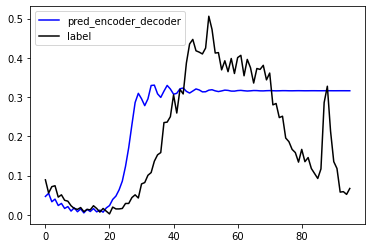

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


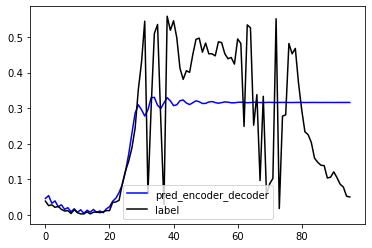

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


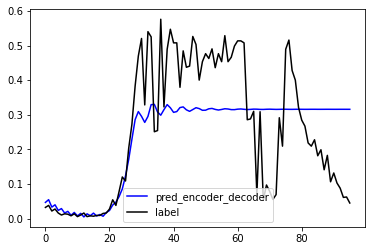

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


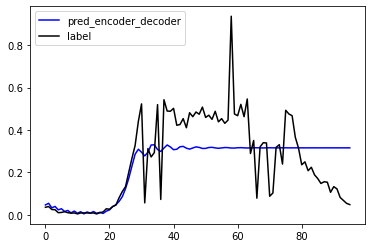

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


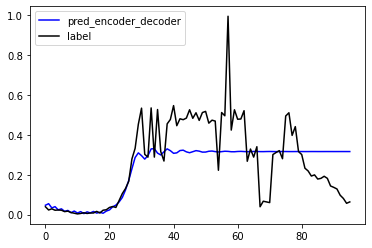

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


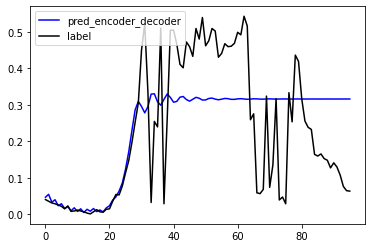

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


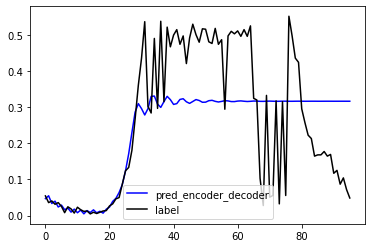

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


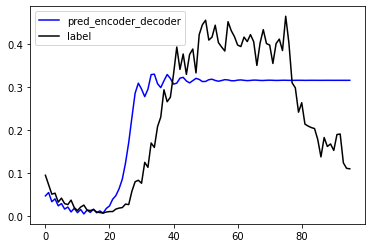

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


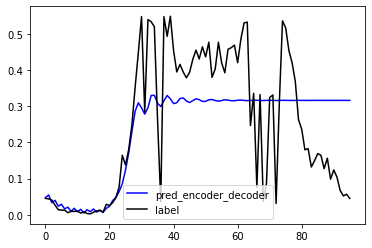

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


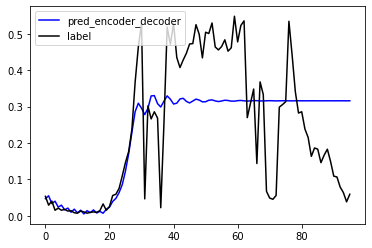

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


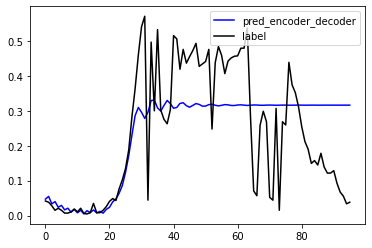

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


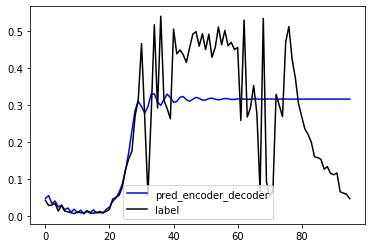

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


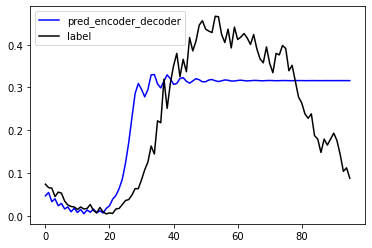

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


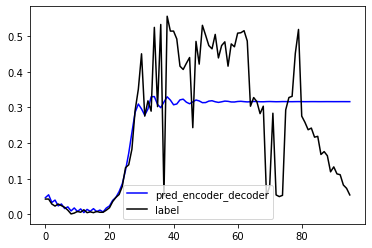

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


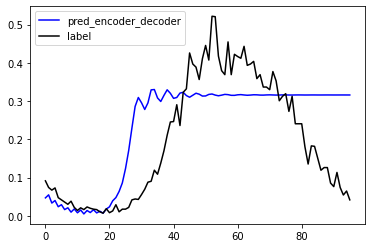

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


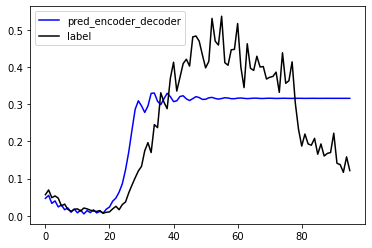

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


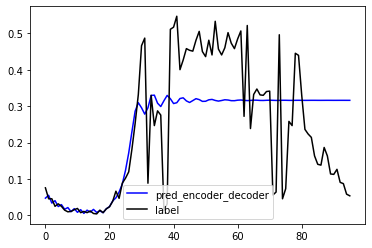

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


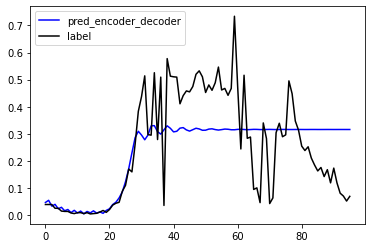

In [16]:
plot_predict({"encoder_decoder":model_seq2seq_lr3},trainloader,96)

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


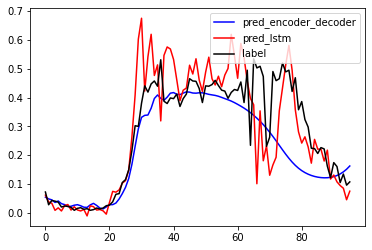

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


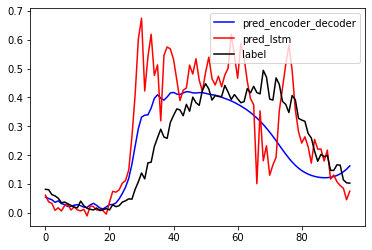

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


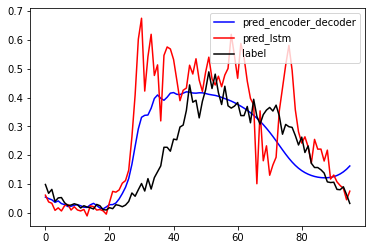

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


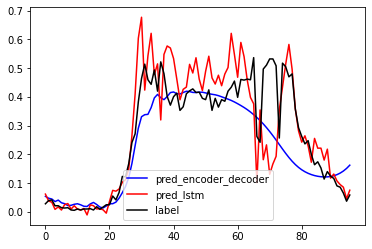

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


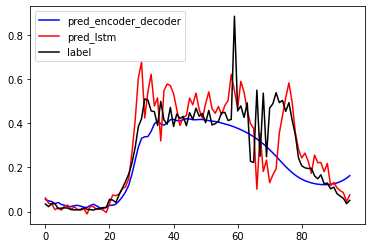

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


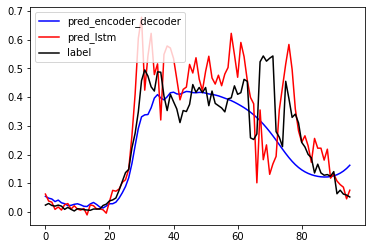

torch.Size([96, 1, 1])
torch.Size([1, 96])
(96,)


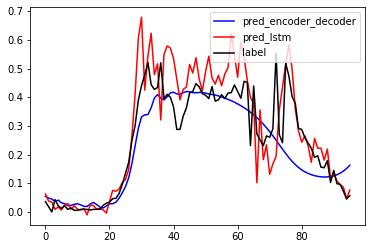

In [70]:
plot_predict({"encoder_decoder":model_seq2seq_lr3,"lstm":model},testloader,96)

In [17]:
input_dim = INPUT_SIZE   
hidden_dim = 256
layer_dim = 2
output_dim = OUTPUT_SIZE
seq_dim = 1

lr = 0.05
n_epochs = 300
iterations_per_epoch = len(trainloader)
name_model = "simple_model_smalldataset_lr5e-2"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
model=LSTM(input_size=input_dim,hidden_size=hidden_dim,output_size=output_dim)


In [53]:
iteration_sm,loss_train_list_sm,loss_val_list_sm=train(model, trainloader, valloader, lr=lr, n_epochs=n_epochs, name_model=name_model, device=device, ite_print=5,save=True)

/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 96])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 loss train 0.008406988345086575 loss val 0.00733605632558465


/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/iris/opt/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch 6 loss train 0.003726701717823744 loss val 0.0063735670410096645
epoch 11 loss train 0.0045509724877774715 loss val 0.006397200282663107
epoch 16 loss train 0.004224316217005253 loss val 0.006593207363039255
epoch 21 loss train 0.009880243800580502 loss val 0.007390396669507027
epoch 26 loss train 0.009210361167788506 loss val 0.007585143204778433
epoch 31 loss train 0.016036540269851685 loss val 0.013288366608321667
epoch 36 loss train 0.005148252472281456 loss val 0.010537125170230865
epoch 41 loss train 0.012951220385730267 loss val 0.013328886590898037
epoch 46 loss train 0.006074537057429552 loss val 0.01793675869703293
epoch 51 loss train 0.013069498352706432 loss val 0.008316755294799805
epoch 56 loss train 0.011490204371511936 loss val 0.012149211950600147
epoch 61 loss train 0.004649559035897255 loss val 0.009737054817378521
epoch 66 loss train 0.008686024695634842 loss val 0.010134434327483177
epoch 71 loss train 0.008943570777773857 loss val 0.013642181642353535
epoch 